In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import pickle
import time

C:\Users\Cyril de Kock\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
np.random.seed(0)

In [3]:
INDIVIDUALS = 50
P_CROSS = 0.6
P_MUTATION = 0.1

In [10]:
def euclidean(s):
    # https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

def euc_fitness(individual, target, pred, label, l1=0.5, l2=0.5, N = 50, n_classes=10):
    # petras fitness fucntion
    return -(l1*euclidean(individual-target)/N + l2*euclidean(pred-label)/n_classes)

def pop_fitness(pop, target, predictions, label):
    return [euc_fitness(p, target, pred, label) for p, pred in zip(pop, predictions)]

def flatten(imgs):
    # flatten all images in np array or list
    return np.array([im.flatten() for im in imgs])

def gaussian_noise():
    # draw one sample of noise from zero mean 1 variance Gaussian
    return np.random.normal(0, np.sqrt(0.1))

def add_noise(image):
    return np.array([x + gaussian_noise() for x in image])

def k_crossover(im1, im2, k=2):
    c1, c2 = [], []
    # get k crossover points
    points = sorted([np.random.randint(0, 783, 1) for p in range(k)])
    im_1_split = np.split(im1, [int(p) for p in points])
    im_2_split = np.split(im2, [int(p) for p in points])
    
    # alternate between lists to realise crossover (theres got to be a more clever way to do this)
    for i in range(k+1):
        if i % 2 == 0:
            c1.append(im_1_split[i])
            c2.append(im_2_split[i])
        else:
            c1.append(im_2_split[i])
            c2.append(im_1_split[i])
    return np.concatenate(c1, axis=0), np.concatenate(c2, axis=0)

def tournament_selection(pop, preds, target_im, target_l, k=3):
    # this function is bad, will fix someday
    rep = False
    pop = np.array(pop)
    if pop.shape[0] < 3:
        print('pop_size<3')
        rep = True
    tournament_indexes = np.random.choice(pop.shape[0], k, replace=rep)
    candidates = pop[tournament_indexes]
    preds_candidates = preds[tournament_indexes]
    parent_scores = [euc_fitness(ind, target_im, p, target_l) for ind,p in zip(candidates, preds)]
    cand = candidates[parent_scores.index(max(parent_scores))]
    idx = np.where(np.isin(pop[:,1], cand))
    return cand, idx[0][0]

def check_adverserial(pop, preds, fitness, target):
    for ind, pred, f in zip(pop, preds, fitness):
        if pred == target and f < 0.01:
            return ind
        return None

def init_pop(n, num, data, labels):
    indices = np.where(labels==num)[0]
    n_indices = np.random.choice(indices, n, replace=True)
    sample = np.take(data, n_indices, axis=0)
    return sample, np.full((n), num, dtype=int) # return sample+array of labels

def init_pop_from_sample(n, num, data, labels):
    indices = np.where(labels==num)[0]
    index = np.random.choice(indices, 1)
    sample = np.take(data, index, axis=0)
    x = np.array([add_noise(sample) for i in range(n)])
    return x.reshape(n, 784), sample

def save_model(model, filename='SVC_model.sav'):
    pickle.dump(model, open(filename, 'wb'))
    
def load_model(filename='SVC_model.sav'):
    return pickle.load(open(filename, 'rb'))

In [5]:
# load mnist
(x_train, y), (x_test, y_t) = tf.keras.datasets.mnist.load_data()
X = flatten(x_train)
X_t = flatten(x_test)

In [6]:
#svm = SVC(C=1, kernel='rbf')
#svm.fit(X, y_train)
#svm.score(X_t, y_test)
#save_model(svm)
model = load_model()

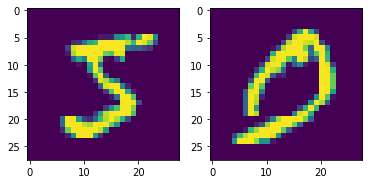

In [7]:
# Examples of crossover
v, w = k_crossover(X[0],X[1])
fig, ax = plt.subplots(1,2)
ax[0].imshow(v.reshape(28,28)) 
ax[1].imshow(w.reshape(28,28))

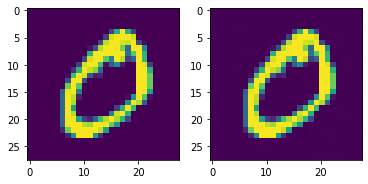

In [8]:
# examples of noise
fig, ax = plt.subplots(1,2)
ax[0].imshow(X[1].reshape(28,28)) 
ax[1].imshow(add_noise(X[1]).reshape(28,28))

In [11]:
def ga(num, data, labels, max_gen, target, individuals = INDIVIDUALS, p_cross = P_CROSS, p_mut = P_MUTATION):
    
    # initialize population by drawing 1 sample from passed dataset, automatically applies noise to all copies
    # Then take predictions to calculate population fitness
    pop, ground_truth = init_pop_from_sample(individuals, num, data, labels)
    predictions = model.predict(pop)
    fit_vals = pop_fitness(pop, ground_truth, predictions, target)

    for gen in range(max_gen):
        if gen % 10 == 0:
            print(f'fitting gen: {gen}')
            print(fit_vals)

        adverserial = check_adverserial(pop, predictions, fit_vals, target)
        if adverserial:
            return adverserial
        
        new_pop = []
        for i in range(individuals//2):
                            
            parent1, idx1 = tournament_selection(pop, predictions, ground_truth, target) 
            parent2, idx2 = tournament_selection(pop, predictions, ground_truth, target)
            if p_cross > np.random.uniform(0.0, 1.0):
                
                #child1, child2 = np.array([]), np.array([])
                child1, child2 = k_crossover(parent1, parent2) # crossover
                if p_mut > np.random.uniform(0.0, 1.0):
                    child1, child2 = add_noise(child1), add_noise(child2) # apply mutation to pixels     
                #if child1.size != 0:
                new_pop.append(child1)
                new_pop.append(child2)
            else:
                new_pop.append(parent1)
                new_pop.append(parent2)
            #print(len(pop))
            #pop.pop(idx1[0])
            #pop.pop(idx2[0])
            if idx1 != idx2:
                order = sorted([idx1, idx2], reverse = True)
                pop = np.delete(pop, order[0], axis=0)
                pop = np.delete(pop, order[1], axis=0)
            else:
                order = idx1
                pop = np.delete(pop, order, axis=0)

            print(order)
            print(pop.shape)

                
        pop = np.array(new_pop)
        predictions = model.predict(pop)
        fit_vals = pop_fitness(pop, ground_truth, predictions, target)
    return pop[fit_vals.index(max(fit_vals))]
    
start = time.process_time()
adverserial = ga(7, X, y, 1, 1)
print(time.process_time() - start)

6.45633045469691
8.570356637212715
6.528812341288169
6.753426563893234
1.9036012691177555
1.7171521895985318
19.62080144036594
5.010122675481259
19.338686254378537
0.7927196117679174
12.137325064150264
1.284362907199646
1.678284254765832
1.510255016623558
15.898790030860466
11.758388223843243
12.36153184267642
3.9274918401243544
0.8593209678149487
11.961964080124435
11.202967854709408
6.209928431816542
9.671263215247652
2.206655688018705
7.78937631877802
1.0902153780235373
4.762521462814212
2.578408496655295
3.431032713314471
11.718343243702565
11.448252642986553
6.826635118903141
19.444524891867747
11.097459289512296
3.4069919479992032
8.36305146005283
0.9654374867792669
18.467081013513887
19.303328236501166
2.4925418521095257
7.978857907431543
6.404785587080349
2.0583231501711214
4.234911231373841
11.30902879941044
12.895345533360384
1.7676644856758115
3.3932042058252523
5.474262957810771
15.706356307642192
fitting gen: 0
[-0.36456330454696906, -0.3857035663721271, -0.365288123412881

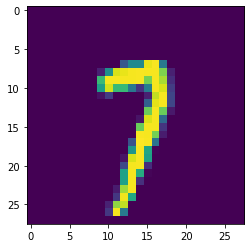

In [10]:
plt.imshow(adverserial.reshape(28,28))

In [12]:
model.predict(adverserial.reshape(1,-1))

array([7], dtype=uint8)

In [ ]:
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, typecode="d", fitness=creator.FitnessMax, strategy=None)
creator.create("Strategy", np.ndarray, typecode="d")

tbx = base.Toolbox()
INDIVIDUAL_SIZE = 784


tbx.register("attr_int", random.randint, 0, 1)
tbx.register("individual", 
             tools.initRepeat, 
             creator.Individual,
             tbx.attr_int, 
             n=INDIVIDUAL_SIZE)
tbx.register("population", tools.initRepeat, list, tbx.individual)
tbx.register("evaluate", EOQ)
tbx.register("mate", tools.cxOnePoint)
tbx.register("mutate", tools.mutFlipBit, indpb=0.01)
tbx.register("select", tools.selTournament, tournsize=5)